In [1]:
%matplotlib inline

from mmdet.apis import init_detector, inference_detector
from monai.networks.nets.unetr import UNETR
import torch
from torch.nn.modules.loss import CrossEntropyLoss
from bigkingxxl.discriminator.discriminator import Discriminator
from bigkingxxl.evaluator.evalutator import *
from bigkingxxl.loss.IoULoss import IoULoss
from bigkingxxl.trainer.gan_trainer import GanTrainer
from bigkingxxl.dataset.dataset import SartoriusDataset
from torch.optim import Adam
from torch.nn import BCELoss
from torch.utils.data import DataLoader
import logging
import matplotlib.pyplot as plt
import numpy as np

DEVICE = 'cpu'
SAVE = 'models/2021_11_29_22_39_19_014861/epoch_6_'

# define generator and discriminator
#generator = UNETR(in_channels=1, out_channels=1, img_size=(520, 704), spatial_dims=2)
generator = UNETR(in_channels=1, out_channels=3, img_size=(512, 704), spatial_dims=2).to(DEVICE)
discriminator = Discriminator((4, 512, 704)).to(DEVICE)

generator.load_state_dict(torch.load(SAVE + 'generator.pth'))

train_dataset = SartoriusDataset(dataset_path = './dataset', mode = 'train')
train_dataloader = DataLoader(train_dataset)
# define test data
test_dataset = SartoriusDataset(dataset_path = './dataset', mode = 'test')
test_dataloader = DataLoader(test_dataset)


In [2]:
config = '/home/max/.local/lib/python3.9/site-packages/mmdet/.mim/configs/cascade_rcnn/cascade_mask_rcnn_x101_64x4d_fpn_mstrain_3x_coco.py'
model = init_detector(config, device='cpu')

In [23]:
for inputImage, maskImage in test_dataloader:
    inputImage = inputImage[:, :512, :].reshape(512, 704).float().numpy()
    inputImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB)
    print(inputImage.shape)
    out = inference_detector(model, inputImage)
    print(out)
    break

(512, 704, 3)
img:
(800, 1100, 3)
mean:
(3,)
([array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=float32), array([], shape=(0, 5), dtype=flo

In [28]:
len(out[1])

80

In [24]:
out[1][11][0].shape

IndexError: list index out of range

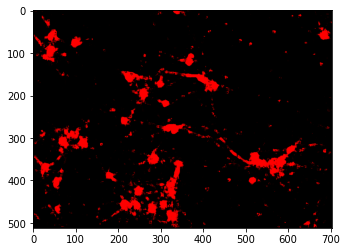

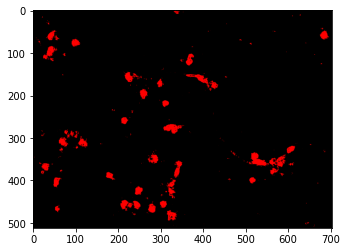

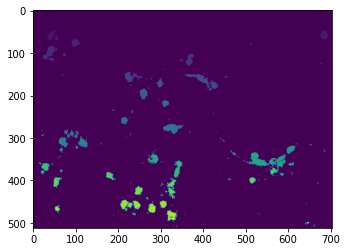

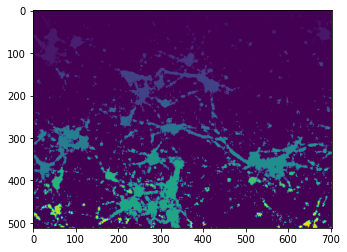

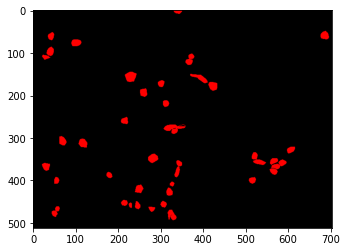

(295, 37)
0.03453374885942214


In [15]:
for inputImage, maskImage in test_dataloader:
    inputImage = inputImage[:, :512, :].reshape(-1, 1, 512, 704).float().to(DEVICE)
    maskImage = maskImage[:, :, :512,:].reshape(-1, 3, 512, 704).float().to(DEVICE)
    retval, mask_components = label_instances(maskImage.reshape(3, 512, 704)[0, :, :].detach().cpu().numpy().astype(np.int8()))
    predictedMask = model(return_loss=False, rescale?inputImage).reshape(3, 512, 704).detach().cpu()
    sigmoided = torch.sigmoid(predictedMask) # 
    clipped = predictedMask.clip(5,6) - 5
    #plt.imshow(predictedMask)
    plt.imshow(sigmoided.permute(1, 2, 0))
    plt.show()
    plt.imshow(clipped.permute(1, 2, 0))
    plt.show()
    #print(predictedMask)
    #print(predictedMask.clip(0,1))
    retval, clipped_components = label_instances((clipped * 255).int()[0, :, :].reshape(512, 704).numpy().astype(np.uint8()))
    plt.imshow(clipped_components)
    plt.show()
    retval, sigmoided_components = label_instances((sigmoided * 255).int()[0, :, :].reshape(512, 704).numpy().astype(np.uint8()))
    plt.imshow(sigmoided_components)
    plt.show()
    plt.imshow(maskImage.reshape(3, 512, 704).detach().cpu().permute(1, 2, 0))
    plt.show()
    print(iou_map([clipped_components], [mask_components]))
    break